In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from pathlib import Path

train = pd.read_csv ('data_titanic/titanic_train_wrangled.csv')
test = pd.read_csv ('data_titanic/titanic_test_wrangled.csv')

In [39]:
# remove unused columns
exclude = ['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 
            'parch', 'ticket', 'fare', 'cabin', 'embarked', 'title', 'age_cat', 'fare_cat',
            'cabin_type']
feature_candidates = train.drop (columns=exclude)
feature_names = list (feature_candidates.columns)

In [40]:
# which features are the most useful
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression ()
lr.fit (feature_candidates, train['survived'])
lr.coef_[0]
corr = pd.Series (lr.coef_[0], index=feature_names)
corr_sorted = corr.abs().sort_values(ascending=False)
feature_names_final = list(corr_sorted.index)[:33]
train_features = train[feature_names_final]
train_target = train['survived']
test_features = test[feature_names_final]

In [4]:
len(corr_sorted)

51

In [5]:
"""
    Convert features to square PNG
"""
def convert_df_to_images (df, target=[], training=True, spread=1):
    import math
    import os
    import glob
    from PIL import Image

    # create images folder if it doesn't exist
    if not os.path.exists ('images_titanic'):
        path = os.makedirs('images_titanic')
    else:
        # clean out directory folder
        files = glob.glob('images_titanic/*.*', recursive=True)
        for f in files:
            os.remove(f)

    # first determine square image size to accommodate features
    sqrt = (df.shape[1])**(0.5)
    sqrval = math.ceil(sqrt) * spread # round up to next int and spread pixels
    for i, row in df.iterrows():
        img = Image.new ('RGB', (sqrval,sqrval), color='black')
        cols = df.shape[1]
        cnt = 0
        for x in range(0, sqrval, spread):
            for y in range(0, sqrval, spread):
                if cnt < cols:
                    if row[cnt] == 0:
                        img.putpixel( (x,y), (0,0,0) )
                    else:
                        img.putpixel( (x,y), (255,255,255) )
                else:
                    # fill in the remaining pixels
                    img.putpixel( (x,y), (0,0,0) )
                cnt += 1
        # write out image file for this row
        if training:
            if target[i] == 0:
                filename = 'images_titanic/' + 'died_' + str(i) + '.png'
            else:
                filename = 'images_titanic/' + 'survived_' + str(i) + '.png'
        else:
            filename = 'images_titanic/' + str(i) + '.png'
        img.save (filename)

In [6]:
convert_df_to_images (train_features, train_target, spread=1)

In [7]:
path_img = Path('images_titanic')
fnames = get_image_files (path_img)
np.random.seed(2)
re_pat = r'/([^/]+)_\d+.png'
data = ImageDataBunch.from_name_re(path_img, fnames, re_pat, ds_tfms=get_transforms(), size=224, bs=64)
n = data.normalize(imagenet_stats)

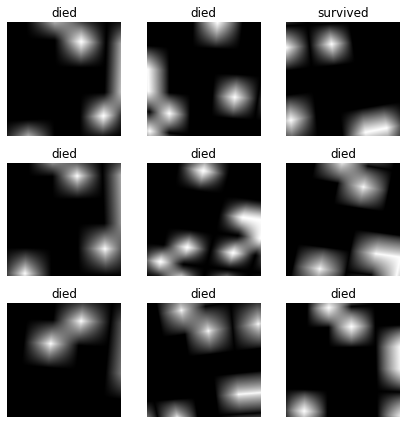

In [8]:
data.show_batch(rows=3, figsize=(6, 6))

In [8]:
data.classes

['died', 'survived']

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, callback_fns=[CSVLogger])

In [8]:
learn.fit_one_cycle (4)
learn.csv_logger.read_logged_file()

epoch,train_loss,valid_loss,error_rate,time
0,1.250885,0.878622,0.601124,00:04
1,1.209799,0.689105,0.325843,00:02
2,1.091710,0.641962,0.275281,00:02
3,1.035804,0.534561,0.207865,00:02


In [10]:
learn.unfreeze()
learn.fit_one_cycle (8)
learn.csv_logger.read_logged_file()

epoch,train_loss,valid_loss,error_rate,time
0,1.144229,0.727049,0.308989,00:04
1,1.030946,1.328008,0.292135,00:03
2,1.017889,0.559755,0.235955,00:03
3,0.954748,0.643051,0.196629,00:03
4,0.873622,0.585922,0.247191,00:03
5,0.790586,0.480467,0.202247,00:03
6,0.729454,0.432213,0.174157,00:03
7,0.691066,0.410154,0.151685,00:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


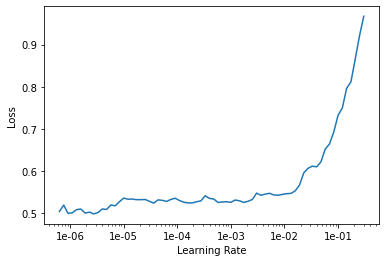

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-61, 1e-54))
learn.csv_logger.read_logged_file()

epoch,train_loss,valid_loss,error_rate,time
0,0.478625,0.414624,0.168539,00:03
1,0.522951,0.411076,0.151685,00:03
2,0.507516,0.408958,0.151685,00:03
3,0.515478,0.408087,0.157303,00:03
4,0.516776,0.411441,0.162921,00:03
5,0.509573,0.409824,0.157303,00:03
6,0.516058,0.408932,0.146067,00:03
7,0.522216,0.409668,0.151685,00:03


In [13]:
learn.save ('stage-1')

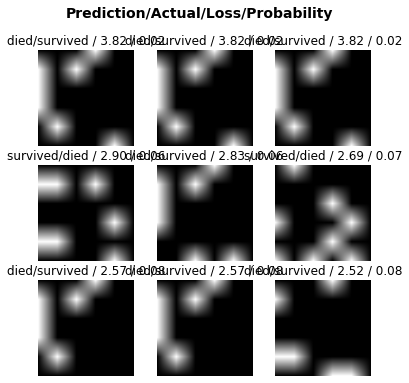

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(6,6))

In [14]:
test_features.shape

(418, 33)

In [41]:
# Generate predictions
learn.load('stage-1')
test['survived'] = 0
convert_df_to_images (test_features, training=False, spread=1)
for i, row in test_features.iterrows():
    filename = 'images_titanic/' + str(i) + '.png' 
    img = open_image(filename)
    pred_class, pred_idx, outputs = learn.predict(img)
    if str(pred_class) == 'survived':
        test.at[i, 'survived'] = 1

In [42]:
# Create the Kaggle submission file
kg_df = pd.DataFrame()
kg_df['PassengerId'] = test['passengerid']
kg_df['Survived'] = test['survived']
kg_df.to_csv ('data_titanic/submission.csv', index=False)